## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
t0 = time.clock()
time.ctime(time.time())

'Tue Jul 17 20:56:51 2018'

In [3]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0.4.0


from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *

from fastai.dataset import *
from fastai.sgdr import *

We use resnet34 (if you are interested in what the trailing number means, see [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) — just different parameters).

See [ResNet-34](https://www.kaggle.com/pytorch/resnet34) for Deep Residual Learning for Image Recognition

In [4]:
from fastai.model import resnet34

In [5]:
PATH = "/data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [6]:
m = arch(True)   # Get the pretrained architecture.

In [7]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Our ResNet model had Relu → BatchNorm. 
TorchVision does BatchNorm →Relu. 
There are three different versions of ResNet floating around, and the best one is [PreAct](https://arxiv.org/pdf/1603.05027.pdf).

We need to predict Dogs vs Cats, (and not ImageNet classes). 
So we need to remove the last layer, because it produces 1000 features (as required for ImageNet). 
When we use `ConvLearner_from_pretrained` from fastai it actually deletes the last (fc)layer, 
and also deletes the previous (avgpool) layer.

Fastai replaces `AvgPool2d` with `AdapativeAveragePooling`, and `AdaptiveMaxPooling` and `concat` them together.

Now we do a simple version, delete the last two layers and add a convolution which has 2 outputs, 
then average pooling, then softmax.
This will result in only 2 numbers as output.

`children(m)[:-2]` - leave out the last two layers

In [8]:
import torch.nn as nn
from fastai.torch_imports import children
from fastai.layers import Flatten

In [9]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1),     # We will train this one
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

- Remove the last two layers
- Add a convolution which just has 2 outputs.
- Do average pooling then softmax
- There is no linear layer at the end. This is a different way of producing just two numbers — which allows us to do CAM!

In [10]:
from fastai.transforms import tfms_from_model, transforms_side_on
from fastai.dataset import ImageClassifierData

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [12]:
from fastai.conv_learner import ConvLearner

In [13]:
learn = ConvLearner.from_model_data(m, data)

Freeze every single layer, except for layer (-4), which is the `nn.Conv2d(512, 2, 3, padding=1)`, which we added.

In [14]:
learn.freeze_to(-4)

In [15]:
m[-1].trainable

True

In [16]:
m[-4].trainable

True

Now train only the (-4) layer.

In [17]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.114581   0.100176   0.99      



[0.10017573156952858, 0.99]

In [18]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.089768   0.099709   0.989     



[0.09970886266231536, 0.989]

- ConvLearner.from_model is what we learned about earlier — allows us to create a Learner object with custom model.
- Then freeze the layer except the ones we just added.

## CAM - Class Activation Maps
We going to use a technique CAM, and ask the model ‘which parts of the picture are useful?<br>
How does this work? It produces a matrix, simply equal to the value of 
`feature` matrix times `py` vector  (the predictions).

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [20]:
x,y = next(iter(data.val_dl))

In [21]:
x,y = x[None,1], y[None,1]
vx = x.cuda()
vx.requires_grad_(True)
type(vx)
#vx = Variable(x.cuda(), requires_grad=True)

torch.Tensor

In [22]:
from matplotlib import pyplot as plt

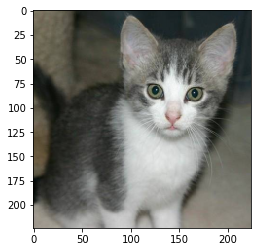

In [23]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [24]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [25]:
%time py = m(x.cuda())   #m(Variable(x.cuda()))

CPU times: user 7.52 ms, sys: 0 ns, total: 7.52 ms
Wall time: 7.13 ms


In [26]:
for o in sfs: o.remove()

In [27]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [28]:
import numpy as np
from fastai.core import to_np

In [29]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [30]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

How did it do this? Let’s work backwards. The way it did it was by producing this matrix:

In [31]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.01966, 0.09945, 0.21811, 0.32309, 0.37615, 0.35048, 0.21065],
       [0.04918, 0.20831, 0.43785, 0.61535, 0.70435, 0.65303, 0.40207],
       [0.08146, 0.29688, 0.59855, 0.84275, 0.96157, 0.89616, 0.55568],
       [0.09242, 0.30243, 0.599  , 0.85043, 1.     , 0.93773, 0.59765],
       [0.07578, 0.21856, 0.42455, 0.62157, 0.77839, 0.77355, 0.51258],
       [0.04803, 0.1089 , 0.19307, 0.29999, 0.424  , 0.45704, 0.31999],
       [0.     , 0.00537, 0.01221, 0.04291, 0.10708, 0.15502, 0.11733]], dtype=float32)

- `py` vector is the predictions that says “I am 100% confident it’s a cat.” 
- `feat` is the values (2×7×7) coming out of the final convolutional layer (the Conv2d layer we added). 
If we multiply feat by py, we get all of the first channel and none of the second channel. 
Therefore, it is going to return the value of the last convolutional layers for the section which lines up with being a cat. 
If we multiply feat by [0, 1] , it will line up with being a dog.

Put it in another way, in the model, the only thing that happened after the convolutional layer 
was an average pooling layer. 
The average pooling layer took took the 7x7 grid and averaged out how much each part is “cat-like”. 
We then took the “cattyness” matrix, resized it to be the same size as the original cat image, 
and overlaid it on top, then you get the heat map.

The way you can use this technique at home is:
1. when you have a large image, you can calculate this matrix on a quick small little convolutional net
2. zoom into the area that has the highest value
3. re-run it just on that part

In [33]:
import skimage
from skimage.transform import resize
skimage.__version__

'0.14.0'

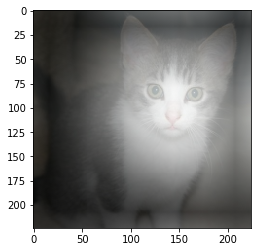

In [34]:
plt.imshow(dx)
#plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');
plt.imshow(skimage.transform.resize(f2, dx.shape, anti_aliasing=True, mode="reflect"), alpha=0.75, cmap='hot');

## Model

In [35]:
learn.unfreeze()
learn.bn_freeze(True)

In [46]:
#lr=np.array([1e-6,1e-4,1e-2])
lr=np.array([1e-6,1e-4,1e-2, .01, .01,.01,.01,.01,.01,.01,.01,.01])

In [47]:
len(learn.models.get_layer_groups())   # changed the default from 3 to 12?

12

In [48]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      nan        nan        0.5       
    1      nan        nan        0.5                       



[nan, 0.5]

#interogativ This is because you are comparing an autograd variable to a tensor. Here's how I got around this:
```
def accuracy1(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    #print ('preds: {}, {}'.format(preds.shape,type(preds)))
    #print ('targs: {}, {}'.format(targs.shape,type(targs)))
    return (preds==targs.data).float().mean()
```

log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

In [39]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      nan        nan        0.5       
    1      nan        nan        0.5                       



[nan, 0.5]

In [40]:
from fastai.metrics import accuracy_np

In [42]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.5

In [41]:
#accuracy_np(*learn.TTA())

AttributeError: 'bool' object has no attribute 'mean'